In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 设置随机种子
np.random.seed(42)

import numpy as np
from sklearn.metrics import accuracy_score

class FeedForwardNNMultiClass:
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, learning_rate=0.01, l2_lambda=0.001):
        """
        初始化双隐藏层前馈神经网络
        结构: Input -> Hidden1 -> Hidden2 -> Output
        """
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.output_dim = output_dim
        self.lr = learning_rate
        self.l2_lambda = l2_lambda
        
        # 初始化权重 (He Initialization)
        self.W1 = np.random.randn(input_dim, hidden_dim1) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, hidden_dim1))
        
        self.W2 = np.random.randn(hidden_dim1, hidden_dim2) * np.sqrt(2.0 / hidden_dim1)
        self.b2 = np.zeros((1, hidden_dim2))
        
        self.W3 = np.random.randn(hidden_dim2, output_dim) * np.sqrt(2.0 / hidden_dim2)
        self.b3 = np.zeros((1, output_dim))
        
        # 初始化记录字典
        self.history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'epochs': []}

    def relu(self, x):
        return np.maximum(0, x)

    def relu_deriv(self, x):
        return np.where(x > 0, 1, 0)

    def softmax(self, x):
        x_max = np.max(x, axis=1, keepdims=True) # 防止溢出
        x_exp = np.exp(x - x_max)
        return x_exp / np.sum(x_exp, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        y_pred = np.clip(y_pred, 1e-8, 1 - 1e-8)
        loss = -np.sum(y_true * np.log(y_pred)) / m
        # L2 正则化项
        l2_loss = 0.5 * self.l2_lambda * (np.sum(self.W1**2) + np.sum(self.W2**2) + np.sum(self.W3**2)) / m
        return loss + l2_loss

    def forward(self, X):
        """前向传播"""
        # Layer 1
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        # Layer 2
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.relu(self.z2)
        # Output Layer
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.softmax(self.z3)
        return self.a3

    def backward(self, X, y_true_onehot):
        """反向传播"""
        m = X.shape[0]
        
        # 1. Output Layer Error
        delta3 = (self.a3 - y_true_onehot) / m
        
        # 2. Hidden Layer 2 Error
        delta2 = np.dot(delta3, self.W3.T) * self.relu_deriv(self.z2)
        
        # 3. Hidden Layer 1 Error
        delta1 = np.dot(delta2, self.W2.T) * self.relu_deriv(self.z1)
        
        # Gradients & Updates
        self.W3 -= self.lr * (np.dot(self.a2.T, delta3) + (self.l2_lambda / m) * self.W3)
        self.b3 -= self.lr * np.sum(delta3, axis=0, keepdims=True)
        
        self.W2 -= self.lr * (np.dot(self.a1.T, delta2) + (self.l2_lambda / m) * self.W2)
        self.b2 -= self.lr * np.sum(delta2, axis=0, keepdims=True)
        
        self.W1 -= self.lr * (np.dot(X.T, delta1) + (self.l2_lambda / m) * self.W1)
        self.b1 -= self.lr * np.sum(delta1, axis=0, keepdims=True)

    def predict(self, X):
        probabilities = self.forward(X)
        return np.argmax(probabilities, axis=1)
    
    def predict_proba(self, X):
        return self.forward(X)

    def _to_onehot(self, y):
        onehot = np.zeros((len(y), self.output_dim))
        onehot[np.arange(len(y)), y.astype(int)] = 1
        return onehot

    def compute_metrics(self, X, y_true):
        """计算指标"""
        y_pred = self.predict(X)
        y_proba = self.forward(X) # 注意：这里会覆盖 self.a, self.z，但在 epoch 结束时不影响训练
        
        if len(y_true.shape) == 1:
            y_true_onehot = self._to_onehot(y_true)
        else:
            y_true_onehot = y_true
            
        loss = self.cross_entropy_loss(y_true_onehot, y_proba)
        accuracy = accuracy_score(y_true, y_pred)
        return loss, accuracy

    def train(self, X_train, y_train, X_test=None, y_test=None, 
              epochs=50, batch_size=64, verbose=True, early_stopping=True, patience=5):
        m = X_train.shape[0]
        y_train_onehot = self._to_onehot(y_train)
        
        best_test_loss = float('inf')
        patience_counter = 0
        best_weights = None
        
        for epoch in range(epochs):
            # Shuffle
            indices = np.random.permutation(m)
            X_shuffled = X_train[indices]
            y_shuffled = y_train_onehot[indices]
            
            # Mini-batch Gradient Descent
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                self.forward(X_batch)
                self.backward(X_batch, y_batch)
            
            # --- 指标计算 ---
            train_loss, train_acc = self.compute_metrics(X_train, y_train)
            
            # --- FIX: 将指标存入 history ---
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['epochs'].append(epoch + 1)
            
            if X_test is not None:
                test_loss, test_acc = self.compute_metrics(X_test, y_test)
                # --- FIX: 将测试集指标存入 history ---
                self.history['test_loss'].append(test_loss)
                self.history['test_acc'].append(test_acc)
                
                if verbose and (epoch + 1) % 1 == 0:
                    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")
                
                # Early Stopping logic
                if early_stopping:
                    if test_loss < best_test_loss:
                        best_test_loss = test_loss
                        patience_counter = 0
                        best_weights = {
                            'W1': self.W1.copy(), 'b1': self.b1.copy(),
                            'W2': self.W2.copy(), 'b2': self.b2.copy(),
                            'W3': self.W3.copy(), 'b3': self.b3.copy()
                        }
                    else:
                        patience_counter += 1
                        if patience_counter >= patience:
                            print(f"早停触发于 Epoch {epoch+1}")
                            if best_weights:
                                self.W1, self.b1 = best_weights['W1'], best_weights['b1']
                                self.W2, self.b2 = best_weights['W2'], best_weights['b2']
                                self.W3, self.b3 = best_weights['W3'], best_weights['b3']
                            break
            else:
                # 如果没有测试集，也要占位或者只打印训练集
                self.history['test_loss'].append(None)
                self.history['test_acc'].append(None)
                if verbose:
                    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")


Loading MNIST dataset...


d:\Miniconda\envs\yolov5\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Preprocessing data...
训练集形状: X=(60000, 784), y=(60000,)
测试集形状: X=(10000, 784), y=(10000,)
类别分布: [5917 6752 5991 6121 5849 5411 5894 6251 5850 5964]

样本图像:


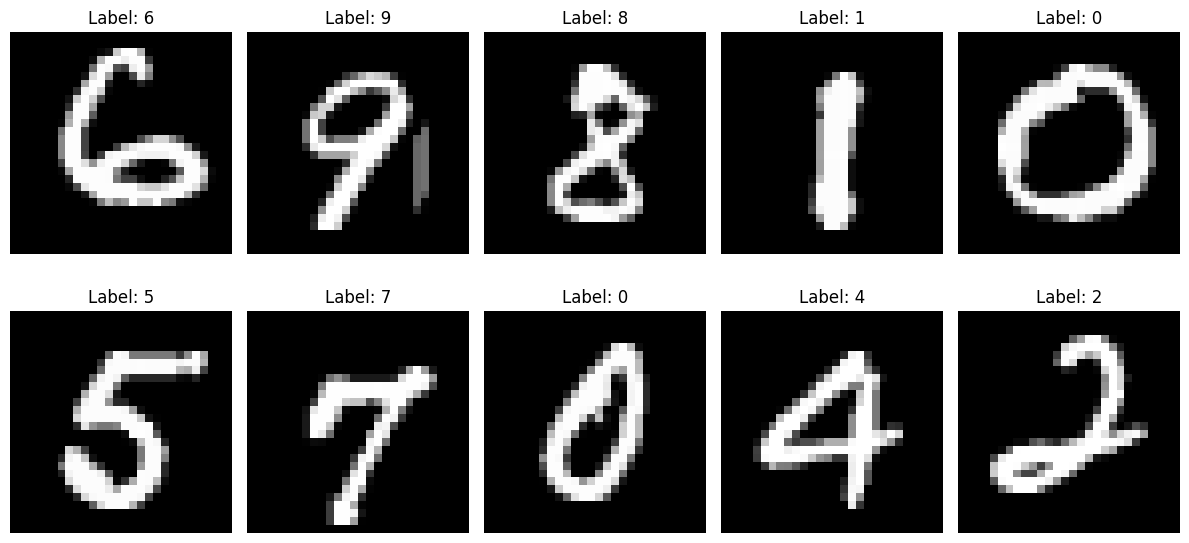

In [2]:

# 加载MNIST数据集
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target'].astype(int)

# 数据预处理
print("Preprocessing data...")
# 归一化到[0, 1]
X = X / 255.0

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, train_size=60000, random_state=42, stratify=y
)

print(f"训练集形状: X={X_train.shape}, y={y_train.shape}")
print(f"测试集形状: X={X_test.shape}, y={y_test.shape}")
print(f"类别分布: {np.bincount(y_train)}")

# 可视化一些样本
def plot_sample_images(X, y, num_samples=10):
    """绘制样本图像"""
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            ax.imshow(X[i].reshape(28, 28), cmap='gray')
            ax.set_title(f'Label: {y[i]}')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

print("\n样本图像:")
plot_sample_images(X_train, y_train)


In [3]:
# 创建并训练模型
print("\nCreating neural network model...")
model = FeedForwardNNMultiClass(
    input_dim=784,      # 28x28像素
    hidden_dim1=256,
    hidden_dim2=128,          # 隐藏层神经元数量
    output_dim=10,      # 10个数字类别
    learning_rate=0.001,
    l2_lambda=0.001
)

print("Starting training...")
model.train(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    epochs=100,
    batch_size=128,
    verbose=True,
    early_stopping=True,
    patience=10
)



Creating neural network model...
Starting training...
Epoch 1/100 | Train Loss: 1.9193 Acc: 0.4888 | Test Loss: 1.9214 Acc: 0.4862
Epoch 2/100 | Train Loss: 1.5376 Acc: 0.6827 | Test Loss: 1.5393 Acc: 0.6803
Epoch 3/100 | Train Loss: 1.2170 Acc: 0.7482 | Test Loss: 1.2183 Acc: 0.7471
Epoch 4/100 | Train Loss: 0.9878 Acc: 0.7897 | Test Loss: 0.9887 Acc: 0.7879
Epoch 5/100 | Train Loss: 0.8343 Acc: 0.8150 | Test Loss: 0.8350 Acc: 0.8123
Epoch 6/100 | Train Loss: 0.7302 Acc: 0.8329 | Test Loss: 0.7309 Acc: 0.8306
Epoch 7/100 | Train Loss: 0.6569 Acc: 0.8440 | Test Loss: 0.6574 Acc: 0.8396
Epoch 8/100 | Train Loss: 0.6029 Acc: 0.8535 | Test Loss: 0.6037 Acc: 0.8494
Epoch 9/100 | Train Loss: 0.5613 Acc: 0.8601 | Test Loss: 0.5622 Acc: 0.8586
Epoch 10/100 | Train Loss: 0.5285 Acc: 0.8665 | Test Loss: 0.5293 Acc: 0.8631
Epoch 11/100 | Train Loss: 0.5019 Acc: 0.8719 | Test Loss: 0.5027 Acc: 0.8682
Epoch 12/100 | Train Loss: 0.4798 Acc: 0.8758 | Test Loss: 0.4805 Acc: 0.8734
Epoch 13/100 | Tra

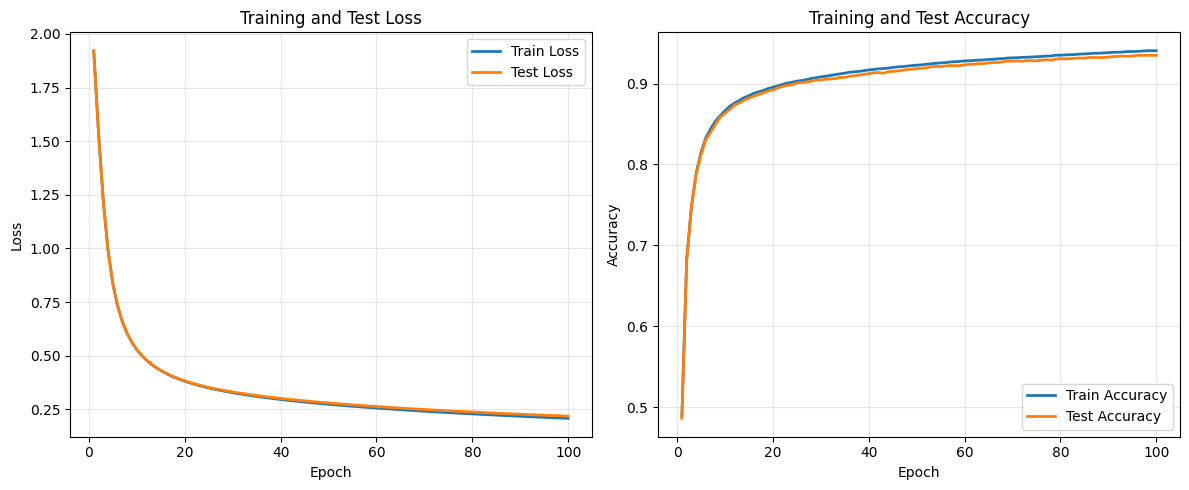


Model Evaluation:

Train Set Evaluation Results:
Accuracy: 0.9405

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5917
           1       0.96      0.98      0.97      6752
           2       0.94      0.93      0.93      5991
           3       0.94      0.91      0.92      6121
           4       0.93      0.94      0.94      5849
           5       0.93      0.92      0.93      5411
           6       0.95      0.96      0.96      5894
           7       0.95      0.94      0.95      6251
           8       0.92      0.92      0.92      5850
           9       0.92      0.92      0.92      5964

    accuracy                           0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000



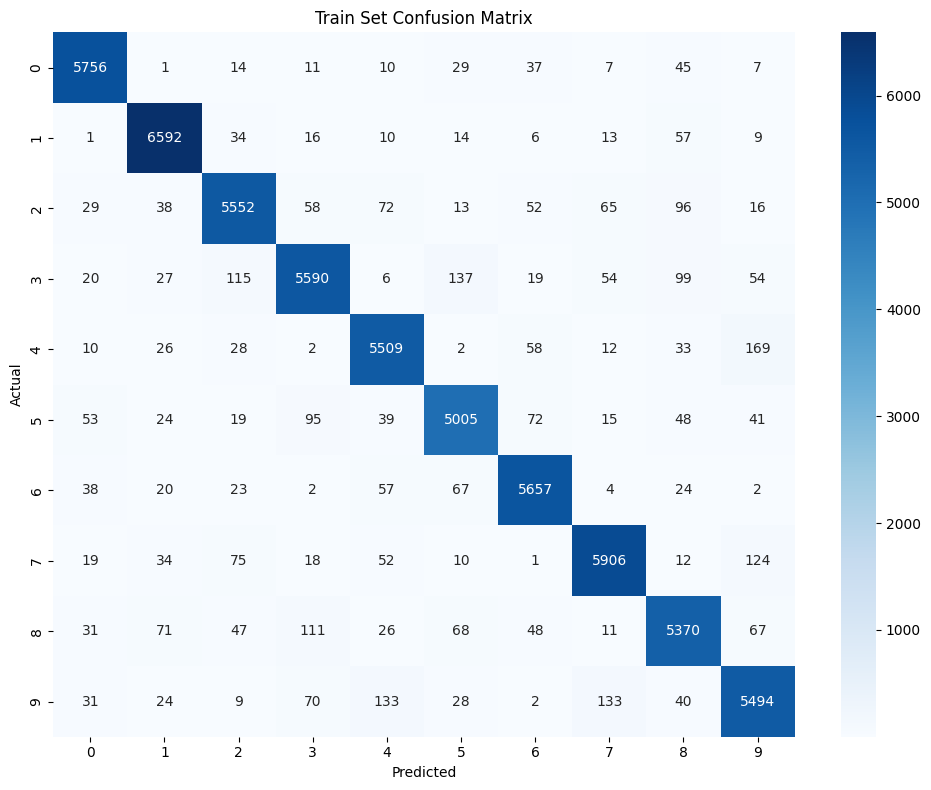


Test Set Evaluation Results:
Accuracy: 0.9347

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       986
           1       0.96      0.98      0.97      1125
           2       0.94      0.91      0.93       999
           3       0.92      0.91      0.91      1020
           4       0.94      0.92      0.93       975
           5       0.93      0.91      0.92       902
           6       0.94      0.97      0.95       982
           7       0.95      0.95      0.95      1042
           8       0.91      0.91      0.91       975
           9       0.89      0.91      0.90       994

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



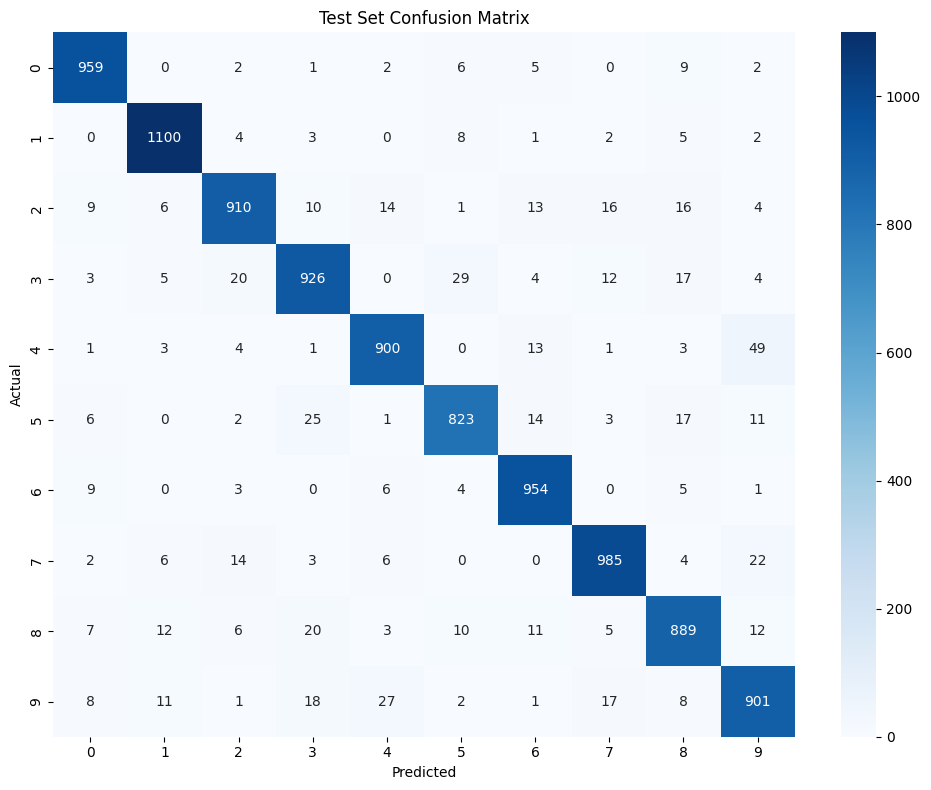


Prediction Examples:


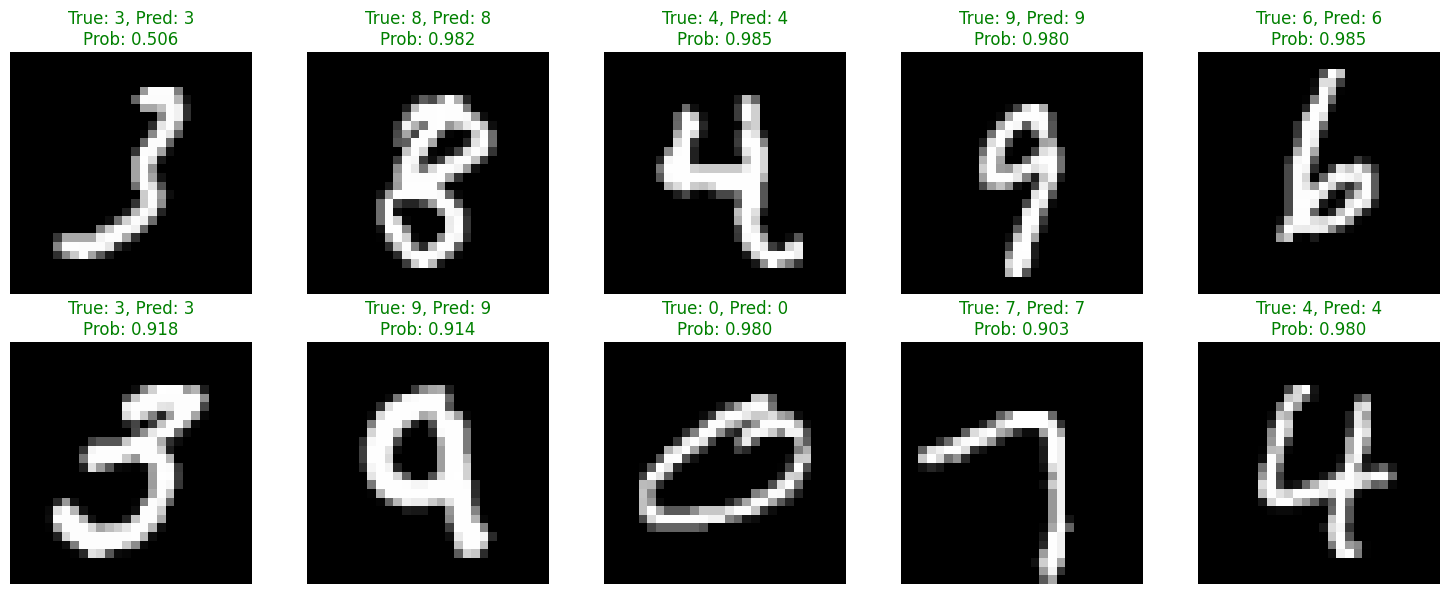


Model Performance Summary
Training Accuracy: 0.9405
Test Accuracy: 0.9347
Number of Epochs: 100


In [4]:

# 绘制训练历史
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # 损失曲线
    ax1.plot(history['epochs'], history['train_loss'], label='Train Loss', linewidth=2)
    if any(loss is not None for loss in history['test_loss']):
        ax1.plot(history['epochs'], history['test_loss'], label='Test Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Test Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 准确率曲线
    ax2.plot(history['epochs'], history['train_acc'], label='Train Accuracy', linewidth=2)
    if any(acc is not None for acc in history['test_acc']):
        ax2.plot(history['epochs'], history['test_acc'], label='Test Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Test Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(model.history)

# 评估模型
def evaluate_model(model, X, y, set_name="Dataset"):
    """全面评估模型性能"""
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)
    
    # 计算各种指标
    accuracy = accuracy_score(y, y_pred)
    
    print(f"\n{set_name} Evaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    
    # 绘制混淆矩阵
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), 
                yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{set_name} Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return accuracy

print("\nModel Evaluation:")
train_accuracy = evaluate_model(model, X_train, y_train, "Train Set")
test_accuracy = evaluate_model(model, X_test, y_test, "Test Set")

# 可视化一些预测结果
def plot_predictions(model, X, y, num_samples=10):
    """可视化预测结果"""
    indices = np.random.choice(len(X), num_samples, replace=False)
    X_sample = X[indices]
    y_true = y[indices]
    y_pred = model.predict(X_sample)
    y_proba = model.predict_proba(X_sample)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            ax.imshow(X_sample[i].reshape(28, 28), cmap='gray')
            pred_prob = y_proba[i][y_pred[i]]
            ax.set_title(f'True: {y_true[i]}, Pred: {y_pred[i]}\nProb: {pred_prob:.3f}', 
                        color='green' if y_true[i] == y_pred[i] else 'red')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

print("\nPrediction Examples:")
plot_predictions(model, X_test, y_test)

# 性能总结
print("\n" + "="*50)
print("Model Performance Summary")
print("="*50)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Number of Epochs: {len(model.history['epochs'])}")
print("="*50)